In [0]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# from data_utils import create_validation_data

use_gpu = torch.cuda.is_available()

from google.colab import drive
drive.mount('/content/gdrive' , force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)

def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

In [0]:
DATA_DIR = '/content/gdrive/My Drive/data_sets/asl/'
train_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}test'

sz = 200
batch_size = 20
embed_size = 29
num_epochs = 10

cnn_name = 'resnet101'

In [0]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(train_dir , transform = tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=32)

valid_ds = datasets.ImageFolder(valid_dir , transform = tfms)
valid_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=32)

In [0]:
class asl_res(nn.Module):
    
    def __init__(self, model, embed_size):
        super(asl_res, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self,x):
        out = self.model(x)
        return out

In [0]:
cnn = get_model(cnn_name)
model = asl_res(cnn, embed_size).cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:01<00:00, 116980832.84it/s]


In [0]:
len(train_ds) , len(valid_ds)

(14500, 899)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

In [0]:
num_epochs = 1
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses += [loss.data.item()]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 20 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) /batch_size, loss.data.item()))

Epoch [ 1/ 1], Step [ 20/725], Loss: 2.7375
Epoch [ 1/ 1], Step [ 40/725], Loss: 1.5967
Epoch [ 1/ 1], Step [ 60/725], Loss: 1.1158
Epoch [ 1/ 1], Step [ 80/725], Loss: 0.6387
Epoch [ 1/ 1], Step [100/725], Loss: 0.4357
Epoch [ 1/ 1], Step [120/725], Loss: 0.3509
Epoch [ 1/ 1], Step [140/725], Loss: 0.2224
Epoch [ 1/ 1], Step [160/725], Loss: 0.1919
Epoch [ 1/ 1], Step [180/725], Loss: 0.1466
Epoch [ 1/ 1], Step [200/725], Loss: 0.1217
Epoch [ 1/ 1], Step [220/725], Loss: 0.1178
Epoch [ 1/ 1], Step [240/725], Loss: 0.1184
Epoch [ 1/ 1], Step [260/725], Loss: 0.0829
Epoch [ 1/ 1], Step [280/725], Loss: 0.1246
Epoch [ 1/ 1], Step [300/725], Loss: 0.0751
Epoch [ 1/ 1], Step [320/725], Loss: 0.0594
Epoch [ 1/ 1], Step [340/725], Loss: 0.0702
Epoch [ 1/ 1], Step [360/725], Loss: 0.0456
Epoch [ 1/ 1], Step [380/725], Loss: 0.0576
Epoch [ 1/ 1], Step [400/725], Loss: 0.0505
Epoch [ 1/ 1], Step [420/725], Loss: 0.0562
Epoch [ 1/ 1], Step [440/725], Loss: 0.0526
Epoch [ 1/ 1], Step [460/725], L

Text(0.5, 1.0, 'Cross Entropy Loss')

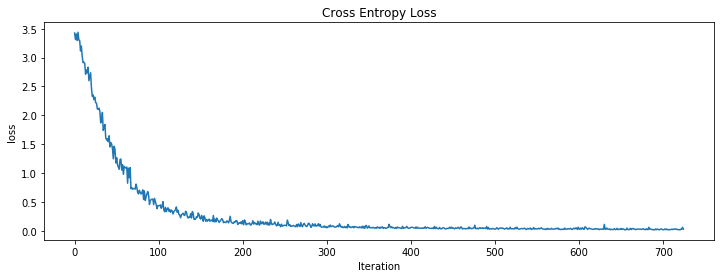

In [0]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')

In [0]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [0]:
evaluate_model(model, valid_dl)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


accuracy: 100.00


In [0]:
def visualize_model(model, dataloader, num_images=6):
    """ Visulaize the prediction of the model on a bunch of random data.
    """
    model.train(False)
    
    images_so_far = 0
    fig = plt.figure(figsize=(10., 8.))

    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = to_var(inputs, volatile=True), to_var(labels, volatile=True)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


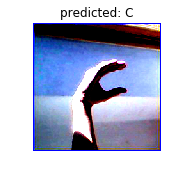

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


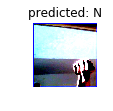

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


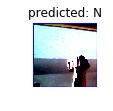

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


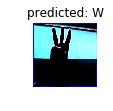

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


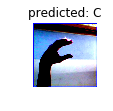

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


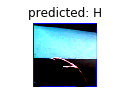

In [0]:
visualize_model(model, valid_dl)